# Tutorial 3: Fixed dimension MCMC with Eryn

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from lisatools.utils.constants import *
from copy import deepcopy  # can be useful

In the third tutorial, we are going to learn how to use MCMC through `Eryn` to do our data analysis investigations. In this tutorial, we will stick with simple examples and simple signals (like in Tutorial 1). In later tutorials, we will use eryn with real GW signals. 

## Task 1: build your own basic MCMC

In order to better understand MCMC and `Eryn`, we are going to start by building our own MCMC algorithm for a simple problem. We will do this with a single-dimensional Gaussian likelihood centered on ($\mu=0$) and a unit standard deviation ($\sigma=1$) and a uniform prior. 

In [2]:
def log_like_gauss(x):
    return -0.5 * x ** 2 - 1/2 * np.log(2 * np.pi * 1.0) # 1.0 is sigma

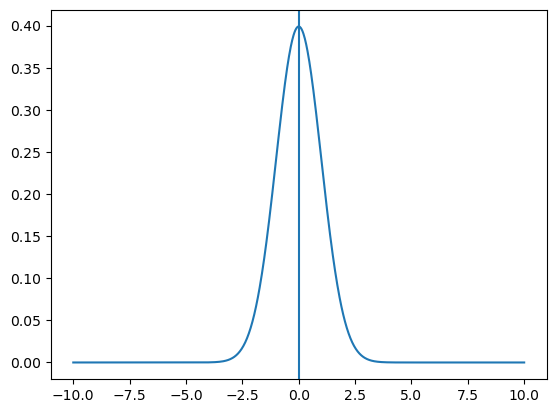

In [3]:
x_vals = np.linspace(-10.0, 10.0, 1000)
# notice the `exp` in there because we are working with the log of the likelihood.
plt.plot(x_vals, np.exp(log_like_gauss(x_vals)))
plt.axvline(0.0)

We are just going to write this into a simple loop. Gather your samples into the chain list.

In [4]:
num_steps = 100000

# get random starting point
current_point = np.random.uniform(-10.0, 10.0)
current_likelihood = log_like_gauss(current_point)
chain = []
for step in range(num_steps):
    # propose new point using a Gaussian distribution with standard deviation of 0.5
    # hint: use current + sigma * N() where N() is a draw from a normal distribution 
    # (np.random.randn)
    new_point = current_point + 0.5 * np.random.randn()

    # get new likelihood
    new_likelihood = log_like_gauss(new_point)

    # calculate the change in posterior
    # here we are using a uniform prior, so its value will not change, so for now do not
    # worry about the prior.
    delta_posterior = new_likelihood - current_likelihood  #  + (new_prior - old_prior)

    # accept or reject
    # if change in log posterior is greater than log(np.random.rand()), accept, else reject
    accept = delta_posterior > np.log(np.random.rand())

    if accept:
        current_point = new_point
        current_likelihood = new_likelihood

    chain.append(current_point)
    

Now plot the chain. You will notice that the beginnning requires a "burn in" phase. So, when calculating the posterior, you must remove this. There are ways to calculate how much burn in is appropriate, but we will not get into that here. 

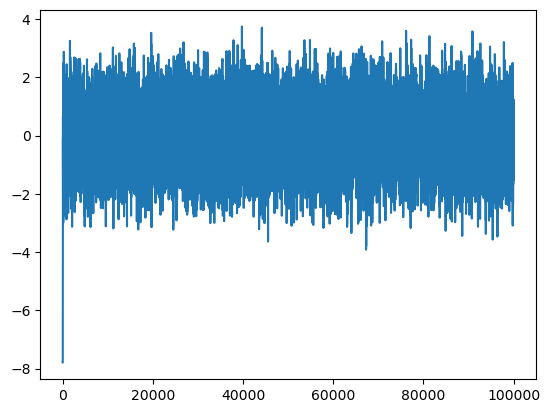

In [5]:
plt.plot(chain)

Plot the posterior distribution generated by the MCMC and compare it against the true Likelihood plot from above. Remember to set `density=True` when building the histogram.

If we take a step back here, we realize MCMC is really just a way to draw samples from a distribution. When the distribution is simple like this example, it will usually be available already with no need to run MCMC (like in scipy). However, in our area of work, the Likelihood distribution tends to be very difficult to deal with, which is why MCMC is so useful for us. To illustrate this, we will draw samples from the same distribution available in Numpy (`np.random.randn`).

(array([2.32059354e-04, 1.16029677e-04, 1.16029677e-03, 1.45037096e-03,
        5.33736514e-03, 8.00604771e-03, 1.06167154e-02, 1.83326890e-02,
        3.09799237e-02, 4.48454701e-02, 6.74712571e-02, 9.25336674e-02,
        1.26994481e-01, 1.66154497e-01, 2.08737389e-01, 2.61995011e-01,
        3.07246585e-01, 3.40373057e-01, 3.79184984e-01, 4.04073350e-01,
        4.14167932e-01, 4.01752756e-01, 3.66305690e-01, 3.31670832e-01,
        2.88275732e-01, 2.39021135e-01, 1.96438243e-01, 1.48343942e-01,
        1.09183926e-01, 7.89001803e-02, 6.09735952e-02, 4.27569360e-02,
        2.86593302e-02, 1.79265851e-02, 9.10832964e-03, 6.38163223e-03,
        3.24883095e-03, 1.33434128e-03, 3.48089031e-04, 6.96178062e-04]),
 array([-3.91785496, -3.72633307, -3.53481119, -3.34328931, -3.15176742,
        -2.96024554, -2.76872366, -2.57720177, -2.38567989, -2.19415801,
        -2.00263612, -1.81111424, -1.61959236, -1.42807048, -1.23654859,
        -1.04502671, -0.85350483, -0.66198294, -0.47046106,

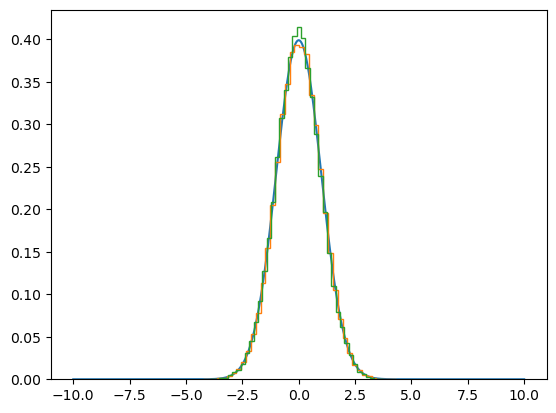

In [6]:
plt.plot(x_vals, np.exp(log_like_gauss(x_vals)))
plt.hist(np.random.randn(100000), bins=40, density=True, histtype="step")
plt.hist(chain[10000:], bins=40, density=True, histtype="step")

## Task 2: Use Eryn to reproduce the above result.

Now use the `EnsembleSampler` in `Eryn` to reproduce the above results. If you are struggling, look at the `Eryn` tutorial. For Eryn, you will need to define a prior. Use `uniform_dist` to create a simple uniform distribution. For this example, you only need to worry about the Ensemble Sampler keyword arguments. Leave those all as default values and only enter the arguments.

Useful documentation:
* [EnsembleSampler](https://mikekatz04.github.io/Eryn/html/user/ensemble.html#eryn.ensemble.EnsembleSampler)
* [State](https://mikekatz04.github.io/Eryn/html/user/state.html#eryn.state.State)
* [uniform_dist](https://mikekatz04.github.io/Eryn/html/user/prior.html#eryn.prior.uniform_dist)
* [ProbDistContainer](https://mikekatz04.github.io/Eryn/html/user/prior.html#eryn.prior.ProbDistContainer)

In [7]:
# imports
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import uniform_dist, ProbDistContainer

Initialize your sampler here. The prior initialization should take the form: `ProbDistContainer({0: prior distribution})`.

In [14]:
prior = ProbDistContainer({
    0: uniform_dist(-1000.0, 1000.0)
})
nwalkers = 20
ndim = 1 
sampler = EnsembleSampler(nwalkers, 1, log_like_gauss, prior)

Now choose your starting point (one for each walker). You can draw from the prior or not. Just make sure to remove any burn in at the end. Then put the starting point into a `State` object. The key here is the start point should have shape `(1, nwalkers, 1, ndim)`. Here the two 1s are for temperatures (which we are not using right now) and the number of leaves or model count (this is for RJ). After this is complete, run the sampler.

Documentation:
* [run_mcmc](https://mikekatz04.github.io/Eryn/html/user/ensemble.html#eryn.ensemble.EnsembleSampler.run_mcmc)

In [15]:
start_point = prior.rvs(size=(1, nwalkers, 1))
start_state = State(start_point)

In [16]:
end_point = sampler.run_mcmc(start_state, 10000, progress=True)

100%|████████████████████████████████████| 10000/10000 [00:17<00:00, 566.21it/s]


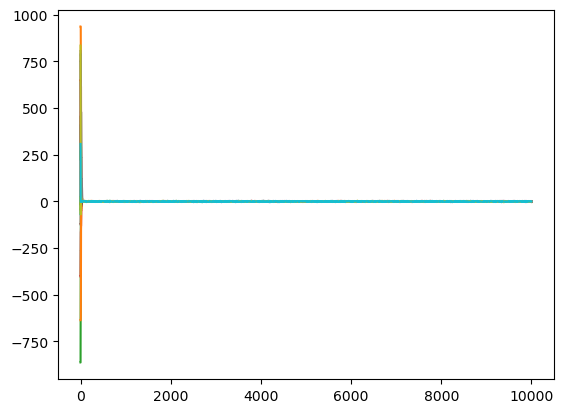

In [17]:
chain = sampler.get_chain()["model_0"]
for w in range(nwalkers):
    plt.plot(chain[:, 0, w, 0])

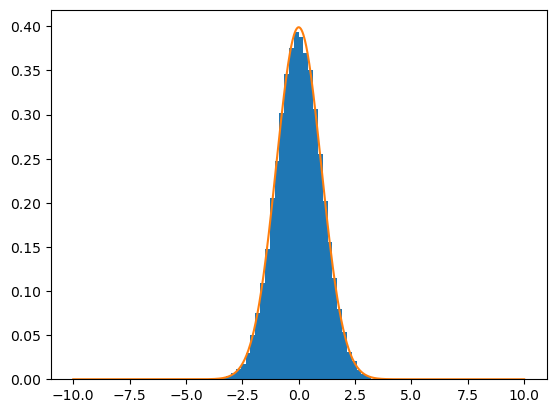

In [19]:
plt.hist(chain[1000:].flatten(), bins=40, density=True)
plt.plot(x_vals, np.exp(log_like_gauss(x_vals)))

## Task 3: Parallel Tempering

In [20]:
from scipy.special import logsumexp

class LogLikeTwoGuass:
    def __init__(self, x_min: float, x_max: float):
        num_for_norm = 100000
        self.norm = 1.0
        x_vals = np.linspace(x_min, x_max, num_for_norm)
        y_vals = np.array([np.exp(self.log_like_two_gauss(x_tmp)) for x_tmp in x_vals])
        self.norm = np.trapz(y_vals, x=x_vals)
        
    def log_like_two_gauss(self, x):
        return logsumexp(np.array([(np.log(0.2) + -0.5 * (x - 50.0) ** 2), (np.log(0.8) + -0.5 * (x + 50.0) ** 2)])) - np.log(self.norm)

In [21]:
like = LogLikeTwoGuass(-1000.0, 1000.0)

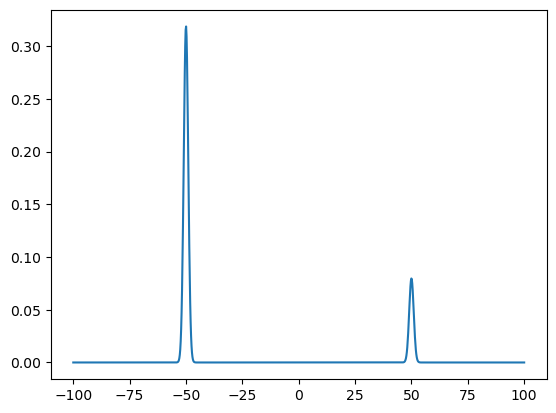

In [22]:
x_vals = np.linspace(-100.0, 100.0, 1000)
# notice the `exp` in there because we are working with the log of the likelihood.
# plt.plot(x_vals, np.exp(log_like_gauss(x_vals)))
plt.plot(x_vals, np.exp(np.array([like.log_like_two_gauss(x_tmp) for x_tmp in x_vals])))


In [23]:
prior = ProbDistContainer({
    0: uniform_dist(-1000.0, 1000.0)
})
nwalkers = 20
ndim = 1 
sampler = EnsembleSampler(nwalkers, 1, like.log_like_two_gauss, prior)

In [24]:
start_point = prior.rvs(size=(1, nwalkers, 1))
start_state = State(start_point)
sampler.run_mcmc(start_state, 10000, progress=True)

100%|████████████████████████████████████| 10000/10000 [00:28<00:00, 356.84it/s]


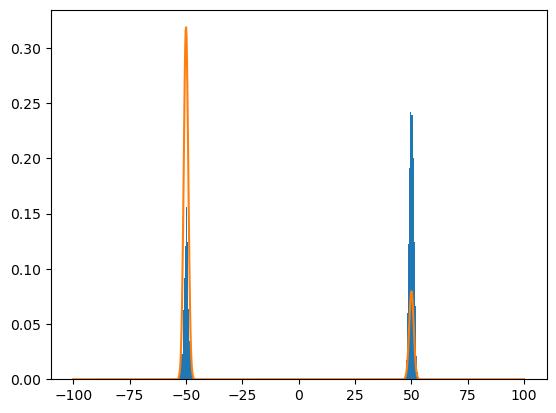

In [25]:
chain = sampler.get_chain()["model_0"][:, 0, :, 0]
plt.hist(chain[7000:].flatten(), bins=np.arange(-75., 75., 0.5), density=True)
plt.plot(x_vals, np.exp(np.array([like.log_like_two_gauss(x_tmp) for x_tmp in x_vals])))

In [27]:
ntemps = 10
sampler_pt = EnsembleSampler(nwalkers, 1, like.log_like_two_gauss, prior, tempering_kwargs=dict(ntemps=ntemps, Tmax=np.inf))

In [28]:
start_point = prior.rvs(size=(ntemps, nwalkers, 1))
start_state = State(start_point)
sampler_pt.run_mcmc(start_state, 10000, progress=True)

100%|█████████████████████████████████████| 10000/10000 [01:53<00:00, 88.47it/s]


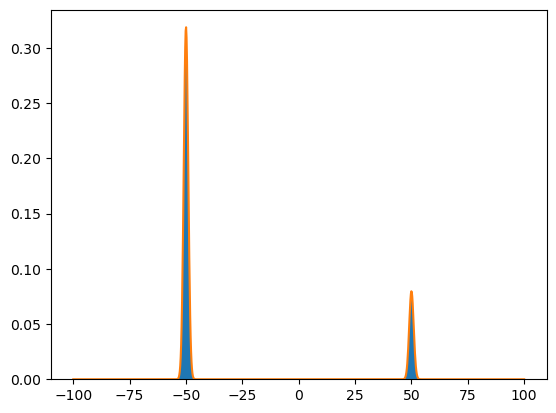

In [30]:
chain = sampler_pt.get_chain()["model_0"][:, 0, :, 0]
plt.hist(chain[1000:].flatten(), bins=np.arange(-75., 75., 0.5), density=True)
plt.plot(x_vals, np.exp(np.array([like.log_like_two_gauss(x_tmp) for x_tmp in x_vals])))

## Task 6: Add GWs!

Now we will add GW signals in the form of the simple Sinusoid we used in the first tutorial. We will start with the waveform function. Set up the `DataResidualArray` (inject whatever parameter you would like), `SensitivityMatrix`, and `AnalysisContainer`. Remember, we do not have a response on this signal, so the sensitivity curve should be `LISASens`. 

In [ ]:
from lisatools.datacontainer import DataResidualArray
from lisatools.analysiscontainer import AnalysisContainer
from lisatools.sensitivity import SensitivityMatrix, LISASens

In [ ]:
def sinusoidal_waveform(A: float, f0: float, phi0: float, t: np.ndarray, **kwargs) -> [np.ndarray, np.ndarray]:
    h1 = A * np.sin(2 * np.pi * (f0 * t) + phi0)
    h2 = A * np.cos(2 * np.pi * (f0 * t) + phi0)
    return [h1, h2]

In [ ]:
dt = 10.0
t_arr = np.arange(100000) * dt
data = DataResidualArray(sinusoidal_waveform(1e-21, 2e-3, np.pi / 3, t_arr), dt=dt)
sens_mat = SensitivityMatrix(data.f_arr, [LISASens, LISASens])
analysis = AnalysisContainer(data, sens_mat, signal_gen=sinusoidal_waveform)

In [ ]:
analysis.calculate_signal_snr(1e-21, 2e-3, 0.0, t_arr)

In [ ]:
priors = ProbDistContainer({
    0: uniform_dist(9e-22, 3e-21),
    1: uniform_dist(1.5e-3, 2.5e-3),
    2: uniform_dist(0.0, 2 * np.pi)
})

ndim = 3
sampler = EnsembleSampler(
    nwalkers,
    ndim, 
    analysis.eryn_likelihood_function,
    priors,
    args=(t_arr,)
)

In [ ]:
start_state = State(priors.rvs(size=(1, nwalkers, 1)))

In [ ]:
sampler.run_mcmc(start_state, 100, progress=True)

In [ ]:
chain = sampler.get_chain()["model_0"]

In [ ]:
plt.plot(chain[:, 0, 0, 0, 1])

## Task 4: Calculate the evidence

In [31]:
from eryn.utils.utility import thermodynamic_integration_log_evidence
nwalkers = 10
ntemps = 50
burn = 2000
sampler_pt_2 = EnsembleSampler(nwalkers, 1, log_like_gauss, prior, tempering_kwargs=dict(stop_adaptation=burn, ntemps=ntemps, Tmax=np.inf))

start_point = prior.rvs(size=(ntemps, nwalkers, 1))
start_state = State(start_point)
sampler_pt_2.run_mcmc(start_state, 10000, burn=burn, progress=True)

logl_avg = sampler_pt_2.get_log_like().mean(axis=(0, 2))
betas = sampler_pt_2.get_betas()[-1]
assert np.all(betas == sampler_pt_2.get_betas()[0])
logz = thermodynamic_integration_log_evidence(betas, logl_avg)
print(logz)

100%|████████████████████████████████████| 10000/10000 [01:31<00:00, 108.71it/s]

(-16.377495621339033, 91.67268447155618)


## Task 5: Model Selection

In [34]:
from scipy.stats import cauchy
def gaussian_pulse(x, a, b):
    f_x = a * np.exp(-((x - b) ** 2) / (2 * 1.0 ** 2))
    return f_x

def cauchy_pulse(x, a, b):
    f_x = a * cauchy.pdf(x - b)
    return f_x

def log_like_fn(params, t, data, sigma, which_template):

    pulse_gen = gaussian_pulse if which_template == "gauss" else cauchy_pulse
    template = pulse_gen(t, *params)

    ll = -0.5 * np.sum(((template - data) / sigma) ** 2, axis=-1)
    return ll

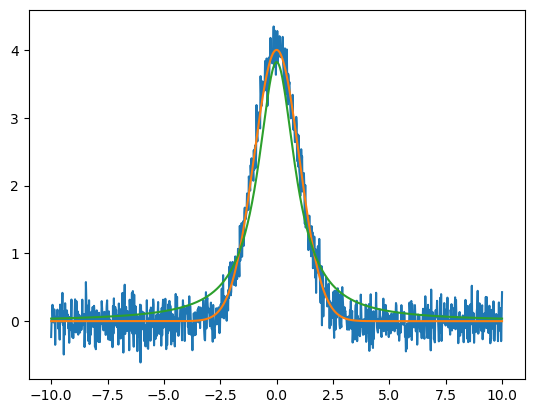

In [42]:
t_vals = np.linspace(-10.0, 10.0, 1000)
sigma = 0.2
amp_true = 4.0
mean_true = 0.0
true_data = gaussian_pulse(t_vals, amp_true, mean_true)
data = true_data + np.random.randn(*t_vals.shape) * sigma
cauchy_data = cauchy_pulse(t_vals, amp_true * 3, mean_true)
plt.plot(t_vals, data)
plt.plot(t_vals, true_data)
plt.plot(t_vals, cauchy_data)
# plt.plot(x_vals, np.exp(log_like_fn()))
# plt.plot(x_vals, np.exp(log_like_gauss(x_vals)))

In [44]:
priors = {}
samplers = {}
burn = 1000
for name in ["gauss", "cauchy"]: 
    priors[name] = ProbDistContainer({
    0: uniform_dist(0.0, 40.0),
    1: uniform_dist(t_vals.min(), t_vals.max())
})
    samplers[name] = EnsembleSampler(
        nwalkers,
        2,
        log_like_fn,
        priors,
        branch_names=[name],
        tempering_kwargs=dict(stop_adaptation=burn, ntemps=ntemps, Tmax=np.inf),
        args=(t_vals, data, sigma, name)
    )

    start_point = priors[name].rvs(size=(ntemps, nwalkers, 1))
    start_state = State({name: start_point})
    samplers[name].run_mcmc(start_state, 10000, burn=burn, progress=True)
    



100%|█████████████████████████████████████| 10000/10000 [08:58<00:00, 18.58it/s]


In [45]:
logz_out = {}
for name in ["gauss", "cauchy"]: 
    logls = samplers[name].get_log_like().mean(axis=(0, 2))
    betas = samplers[name].get_betas()
    assert np.all(betas[-1] == betas[0])
    logz, dlogz = thermodynamic_integration_log_evidence(betas[0], logls)
    print(name, logz, dlogz)
    logz_out[name] = logz

print("2log(Bayes Factor):", 2 * (logz_out["gauss"] - logz_out["cauchy"]))

gauss -502.5554824004948 38.99684312598134
cauchy -1027.723743360916 32.75324723558947
2log(Bayes Factor): 1050.3365219208422
